# Data science project

Identifying the fermentation levels of black tea using computer vision

In [ ]:
!pip install split-folders
!pip install scikit-image

# 1. Problem definition

Fermentation is the most important operation in the tea production process because this step defines the quality of the tea. An underfermented/overfermented tea will sell for less money in the market.

This step in the process has been traditionally done manually by workers and this introduces human mistakes into the equation. Automating this step would improve the quality of the tea as well as reducing costs. 

This notebook replicates a study that used computer vision to classify the level of fermentation in tea. 

Disclosure: project taken from UpLevel - https://dataprojects.uplevel.work/.

## 2. Determining the necessary data

The article provides a dataset which we will download from the following URL: https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/cbpf92vr5j-1.zip. According to the paper, the images were taken in a black tea fermentation environment in a tea factory in Kenya with a 5-megapixel camera.

*   Study: https://www.mdpi.com/2306-5729/5/2/44/htm

## 3. Get/Inspect the data

In [ ]:
!wget https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/cbpf92vr5j-1.zip

--2022-09-05 10:14:51--  https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/cbpf92vr5j-1.zip
Resolving md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)... 52.218.45.186
Connecting to md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)|52.218.45.186|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 478571271 (456M) [application/octet-stream]
Saving to: ‘cbpf92vr5j-1.zip’

cbpf92vr5j-1.zip    100%[===================>] 456.40M  21.5MB/s    in 23s     

2022-09-05 10:15:14 (20.2 MB/s) - ‘cbpf92vr5j-1.zip’ saved [478571271/478571271]



In [ ]:
import zipfile
with zipfile.ZipFile('/content/cbpf92vr5j-1.zip', 'r') as zip_ref:
  zip_ref.extractall()

with zipfile.ZipFile('/content/Black tea fermentation dataset.zip', 'r') as zip_ref:
  zip_ref.extractall()

In [ ]:
import os
for dirpath, dirnames, filenames in os.walk('/content/Black tea fermentation dataset'):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in '/content/Black tea fermentation dataset'.
There are 0 directories and 2000 images in '/content/Black tea fermentation dataset/fermented tea'.
There are 0 directories and 2000 images in '/content/Black tea fermentation dataset/overfermented tea'.
There are 0 directories and 2000 images in '/content/Black tea fermentation dataset/underfermented tea'.


We have three different classes with 2000 images each. The dataset is balanced.

Now, lets split the dataset into training/validation/testing. We will use a 80%/10%/10% split.

In [ ]:
import splitfolders
splitfolders.ratio('Black tea fermentation dataset', output='black_tea', seed=1, 
                  ratio=(0.8, 0.1, 0.1))

Copying files: 6000 files [00:02, 2338.37 files/s]


## 4. EDA

Let's take a look at some samples

In [ ]:
import random
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import pandas as pd

In [ ]:
def show_random_images_from_dir(path, subdirs, n_col=4):
    for j, subdir in enumerate(subdirs):
      all_images = os.listdir(os.path.join(path, subdir))
      choose_random = random.sample(all_images, n_col)
      plt.figure(figsize=(16, 16))
      for i, img_path in enumerate(choose_random):
          temp_img = np.array(Image.open(os.path.join(path, subdir, img_path)))
          plt.subplot(j + 1, n_col, i+1)
          plt.imshow(temp_img)
          plt.title('Shape: ' + str(temp_img.shape) + ' max pix: ' + str(np.max(temp_img)))
          plt.axis(False);

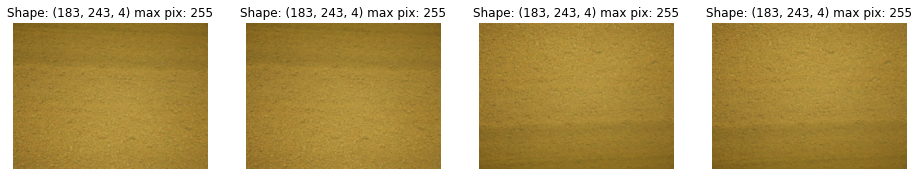

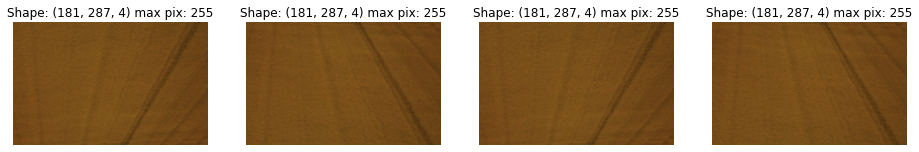

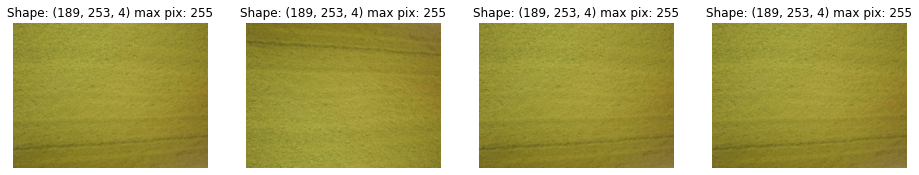

In [ ]:
subdirs = ['fermented tea', 'overfermented tea', 'underfermented tea']
show_random_images_from_dir('/content/black_tea/train', subdirs)

We can infer the following from the previous plots:


1.   Tea has a different color depending on its fermentation stage
2.   Underfermented tea has a green color, overfermented tea brown, and fermented has a color in-between.
3.   Image pixels come in a range from 0-255, so we'll have to normalize them before feeding them to a NN.
4.   Images come in different shapes, we'll have to resize them as well. 
5.   According to the paper, even though its not easily observable in the images, different fermentation stages present different textures as well. The authors define texture as "characteristic intensity variations that originate from the roughness of an object surface".

Images also come with four color channels, let's take a look at their color model

In [ ]:
color_model = Image.open('/content/black_tea/train/fermented tea/fermented.png')
print('Images come in an {} color model'.format(color_model.mode))

Images come in an RGBA color model


Let's read 300 different images from each class and inspect their color distributions more closely

In [ ]:
image_dict = {k: [] for k in subdirs}
for key, value in image_dict.items():
  choose_random = random.sample(os.listdir(os.path.join('/content/black_tea/train', key)), 300)
  for r_image in choose_random:
    temp_img = np.array(Image.open(os.path.join('/content/black_tea/train', key, r_image)))
    image_dict[key].append(temp_img)

In [ ]:
red_fermented = [np.mean(x[:, :, 0]) for x in image_dict['fermented tea']]
blue_fermented = [np.mean(x[:, :, 1]) for x in image_dict['fermented tea']]
green_fermented = [np.mean(x[:, :, 2]) for x in image_dict['fermented tea']]
alpha_fermented = [np.mean(x[:, :, 3]) for x in image_dict['fermented tea']]
fermented_df = pd.DataFrame({'Red': red_fermented, 'Blue': blue_fermented, 'Green': green_fermented,
                             'Alpha': alpha_fermented, 'Stage': 'Fermented'})

red_ovfermented = [np.mean(x[:, :, 0]) for x in image_dict['overfermented tea']]
blue_ovfermented = [np.mean(x[:, :, 1]) for x in image_dict['overfermented tea']]
green_ovfermented = [np.mean(x[:, :, 2]) for x in image_dict['overfermented tea']]
alpha_ovfermented = [np.mean(x[:, :, 3]) for x in image_dict['overfermented tea']]
ovfermented_df = pd.DataFrame({'Red': red_ovfermented, 'Blue': blue_ovfermented, 'Green': green_ovfermented,
                               'Alpha': alpha_ovfermented, 'Stage': 'Overfermented'})

red_undfermented = [np.mean(x[:, :, 0]) for x in image_dict['underfermented tea']]
blue_undfermented = [np.mean(x[:, :, 1]) for x in image_dict['underfermented tea']]
green_undfermented = [np.mean(x[:, :, 2]) for x in image_dict['underfermented tea']]
alpha_undfermented = [np.mean(x[:, :, 3]) for x in image_dict['underfermented tea']]
undfermented_df = pd.DataFrame({'Red': red_undfermented, 'Blue': blue_undfermented, 'Green': green_undfermented,
                                'Alpha': alpha_undfermented, 'Stage': 'Underfermented'})

plot_df = pd.concat([fermented_df, ovfermented_df, undfermented_df], axis=0).melt(id_vars='Stage')

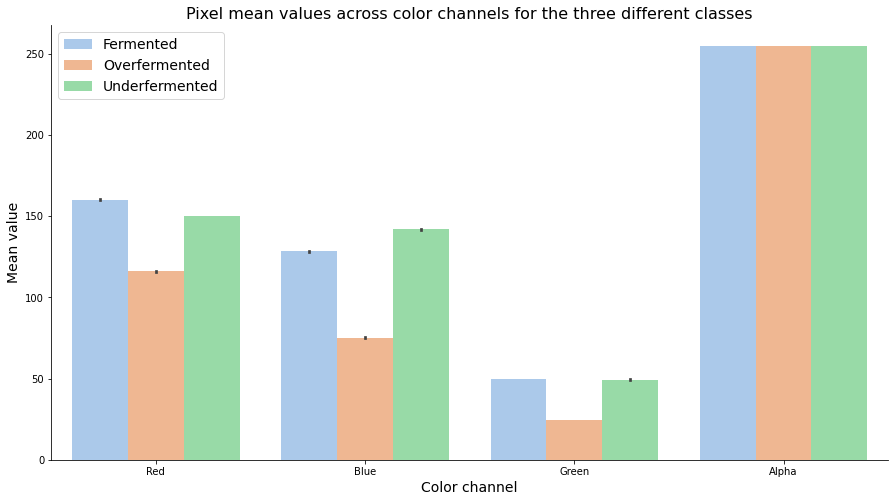

In [ ]:
plt.figure(figsize=(16, 8))
sns.set_palette('pastel')
sns.barplot(data=plot_df, x='variable', y='value', hue='Stage', ci='sd')
plt.ylabel('Mean value', fontsize=14)
plt.xlabel('Color channel', fontsize=14)
plt.title('Pixel mean values across color channels for the three different classes', fontsize=16)
plt.legend(fontsize=14)
sns.despine();

We can see a clear distinction in the mean pixel values across different color channels in the different fermentation stages. 



1.   Overfermented tea has a lower mean value in all color channels.
2.   Fermented and underfermented tea have similar values for the green channel but there's a difference in the red/blue channels.
3. There's low variation in values for the selected sample, as shown by the confidence interval lines.

The fourth color channel in an RGBA model describes the opacity of the pixels. As we can see from the plot, they all have the same values, meaning that the opacity of pixels across different fermentation stages is the same. We can safely drop this channel as it doesn't contain variance across classes.



## 5. Data preparation

We will use the ImageDataGenerator class from Keras to load data in batches to memory.

In [ ]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras import models, losses
from tensorflow import keras

In [ ]:
classes = {
    'underfermented tea': 0,
    'overfermented tea': 1,
    'fermented tea': 2
}

In [ ]:
def preprocess(image):
  image = image[:, :, :3]
  return image

In [ ]:
train_generator = ImageDataGenerator(rescale=1/255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, preprocessing_function=preprocess)
test_generator = ImageDataGenerator(rescale=1/255)
val_generator = ImageDataGenerator(rescale=1/255)

train_path = '/content/black_tea/train/'
val_path = '/content/black_tea/val/'
test_path = '/content/black_tea/test/'

train_set = train_generator.flow_from_directory(train_path, target_size=(150, 150), batch_size=32, class_mode='categorical', classes=classes)
val_set = val_generator.flow_from_directory(val_path, target_size=(150, 150), batch_size=32, class_mode='categorical', classes=classes, shuffle=False)
test_set = test_generator.flow_from_directory(test_path, target_size=(150, 150), batch_size=32, class_mode='categorical', classes=classes, shuffle=False)

Found 4800 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


## 6. Model training

### 6.1 CNN

In [ ]:
# TeaNet implementation

np.random.seed(1000)

#Instantiation
teanet = models.Sequential()

#1st Convolutional Layer
teanet.add(Conv2D(filters=32, input_shape=(150,150,3), kernel_size=(11,11), strides=(4,4), activation='relu'))
teanet.add(BatchNormalization())
teanet.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

#2nd Convolutional Layer
teanet.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1,1), activation='relu'))
teanet.add(BatchNormalization())
teanet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#3rd Convolutional Layer
teanet.add(Conv2D(filters=128, kernel_size=(3,3), strides=(3,3), activation='relu'))
teanet.add(BatchNormalization())
teanet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#Passing it to a Fully Connected layer
teanet.add(Flatten())
# 1st Fully Connected Layer
teanet.add(Dense(512, activation='relu'))
teanet.add(BatchNormalization())
teanet.add(Dropout(0.5))

#2nd Fully Connected Layer
teanet.add(Dense(128, activation='relu'))
teanet.add(BatchNormalization())
teanet.add(Dropout(0.5))

#3rd Fully Connected Layer
teanet.add(Dense(3))
teanet.add(BatchNormalization())
teanet.add(Activation('softmax'))

#Model Summary
teanet.summary()

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
teanet.compile(loss = losses.categorical_crossentropy, optimizer= optimizer, metrics=['accuracy'])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 35, 35, 32)        11648     
                                                                 
 batch_normalization_42 (Bat  (None, 35, 35, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 17, 17, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 15, 15, 64)        18496     
                                                                 
 batch_normalization_43 (Bat  (None, 15, 15, 64)       256       
 chNormalization)                                                
                                                      

In [ ]:
class CustomEarlyStopping(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs['val_accuracy'] > 0.95:
            self.model.stop_training = True

In [ ]:
history = teanet.fit(train_set, epochs=10, verbose=1, validation_data=val_set, callbacks=[CustomEarlyStopping()])

Epoch 1/10
150/150 [==============================] - 67s 439ms/step - loss: 0.1624 - accuracy: 0.9867 - val_loss: 1.0701 - val_accuracy: 0.6667
Epoch 2/10
150/150 [==============================] - 66s 438ms/step - loss: 0.0462 - accuracy: 1.0000 - val_loss: 0.0414 - val_accuracy: 1.0000


In [ ]:
oos_predictions = np.argmax(teanet.predict(test_set), axis=1)

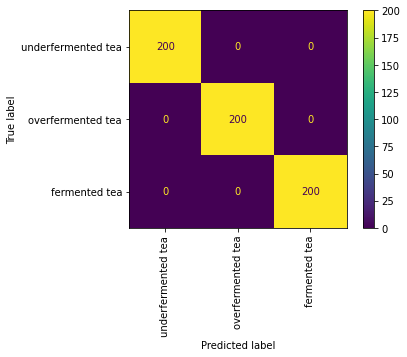

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
cm = confusion_matrix(test_set.classes, oos_predictions)
disp = ConfusionMatrixDisplay(cm, display_labels=classes.keys())
disp.plot(xticks_rotation='vertical');

Great! Our model perfectly predicted every out-of-sample instance.

## 6.2 Local binary patterns

As stated earlier, the texture of tea changes during the fermentation process. 

Local binary patterns is a powerful algorithm for texture classification. We will attempt to tackle the problem using this method as well.

In [ ]:
from skimage.feature import local_binary_pattern
import cv2 as cv
from matplotlib import image as mpimg

First, we'll create a list with all paths in the training dataset

In [ ]:
def load_filenames(dir, subdirs=['fermented tea', 'overfermented tea', 'underfermented tea']):
  """
  Returns list of filepaths for each subdir in dir
  """
  all_files = []
  for subdir in subdirs:
    temp_path = os.path.join(dir, subdir)
    dir_files = os.listdir(temp_path)
    all_files.append([temp_path + '/' + x for x in dir_files])
  
  all_files = [item for sublist in all_files for item in sublist]
  return all_files

In [ ]:
train_files = load_filenames('/content/black_tea/train')
val_files = load_filenames('/content/black_tea/val')
test_files = load_filenames('/content/black_tea/test')

In [ ]:
def preprocess_files(file_list, bins=20):
  """
  Given a list of files, loads files into memory and performs the following operations:

    1.   Transform the image to grayscale
    2.   Apply the local binary patterns transformation
    3.   Bin values
    4.   Normalize bins
  
  Returns pd.DataFrame
  """
  labels = []
  lbph_all = []
  BINS = bins
  for file in file_list:
    img = cv.imread(file)
    gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray_img, P=8, R=1).ravel()
    lbph = np.histogram(lbp, bins=BINS)[0]
    lbph = lbph / np.max(lbph)
    lbph_all.append(lbph)
    labels.append(file.split('/')[1])
  lbph_df = pd.DataFrame(lbph_all)
  lbph_df['label'] = list(map(lambda x: x.split('/')[4], file_list))
  
  return lbph_df

In [ ]:
train_df = preprocess_files(train_files)
val_df = preprocess_files(val_files)
test_df = preprocess_files(test_files)

In [ ]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,label
0,0.906712,0.417488,0.268781,0.064347,0.165333,0.161125,0.054290,0.075431,0.103654,0.175082,...,0.083846,0.077894,0.023399,0.101498,0.172311,0.096470,0.173132,0.330768,1.0,fermented tea
1,0.906712,0.417488,0.268781,0.064347,0.165333,0.161125,0.054290,0.075431,0.103654,0.175082,...,0.083846,0.077894,0.023399,0.101498,0.172311,0.096470,0.173132,0.330768,1.0,fermented tea
2,0.831431,0.348853,0.198948,0.068301,0.146133,0.160330,0.051722,0.088156,0.108309,0.142261,...,0.069890,0.073861,0.026904,0.099573,0.187730,0.092227,0.223469,0.383898,1.0,fermented tea
3,0.906712,0.417488,0.268781,0.064347,0.165333,0.161125,0.054290,0.075431,0.103654,0.175082,...,0.083846,0.077894,0.023399,0.101498,0.172311,0.096470,0.173132,0.330768,1.0,fermented tea
4,0.831431,0.348853,0.198948,0.068301,0.146133,0.160330,0.051722,0.088156,0.108309,0.142261,...,0.069890,0.073861,0.026904,0.099573,0.187730,0.092227,0.223469,0.383898,1.0,fermented tea


Let's inspect the distribution of values for the different classes

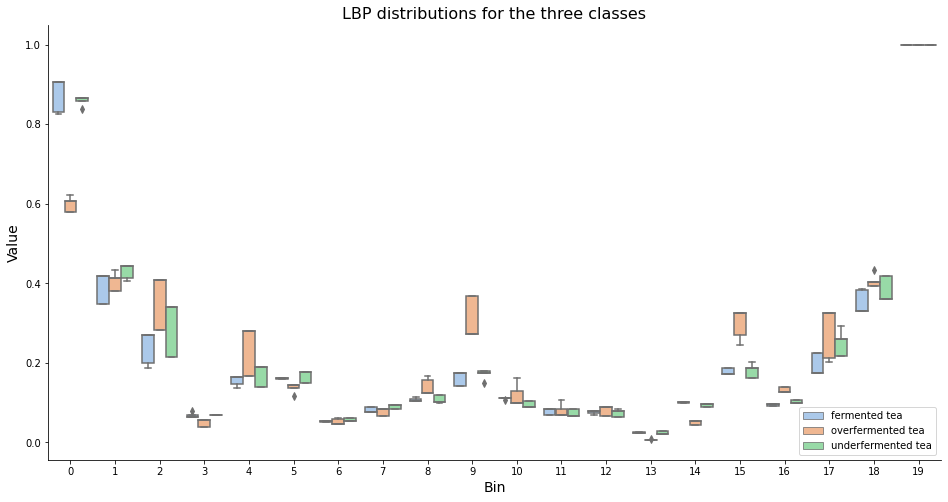

In [ ]:
plt.figure(figsize=(16, 8))
sns.boxplot(data=train_df.melt(id_vars='label'), x='variable', y='value', hue='label')
plt.title('LBP distributions for the three classes', fontsize=16)
plt.xlabel('Bin', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend(fontsize=10, loc='lower right')
sns.despine();

Some of the bins have little to no variation. However, there are others that have much more variation, such as bins 2 and 4. There's also bins that don't overlap, like 14, and 16. We can expect this features to be much more useful for our model. Feature 19 has zero variation, we'll drop that one.

In [ ]:
train_df.drop(labels=[19], axis=1, inplace=True)
val_df.drop(labels=[19], axis=1, inplace=True)
test_df.drop(labels=[19], axis=1, inplace=True)

# Make targets numerical
train_df['label'].replace(classes, inplace=True)
val_df['label'].replace(classes, inplace=True)
test_df['label'].replace(classes, inplace=True)

In [ ]:
x_train = train_df.drop(labels=['label'], axis=1)
x_val = val_df.drop(labels=['label'], axis=1)
x_test = test_df.drop(labels=['label'], axis=1)

y_train = train_df.loc[:, 'label']
y_val = val_df.loc[:, 'label']
y_test = test_df.loc[:, 'label']

Define baseline

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

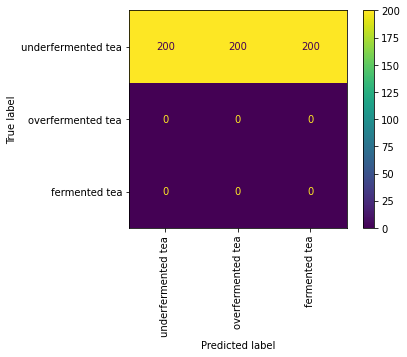

In [ ]:
# Dummy
dummy_classifier = DummyClassifier()
dummy_classifier.fit(x_train, y_train)
preds_dummy = dummy_classifier.predict(x_val)
cm = confusion_matrix(preds_dummy, y_val)
disp = ConfusionMatrixDisplay(cm, display_labels=classes.keys())
disp.plot(xticks_rotation='vertical');

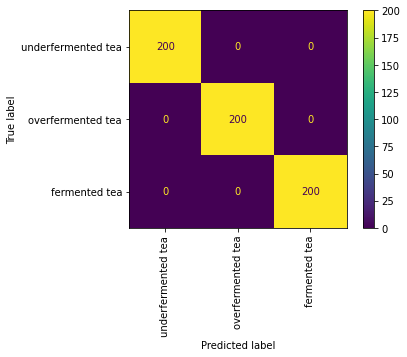

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(x_train, y_train)
preds_clf = clf.predict(x_val)
cm = confusion_matrix(preds_clf, y_val)
disp = ConfusionMatrixDisplay(cm, display_labels=classes.keys())
disp.plot(xticks_rotation='vertical');

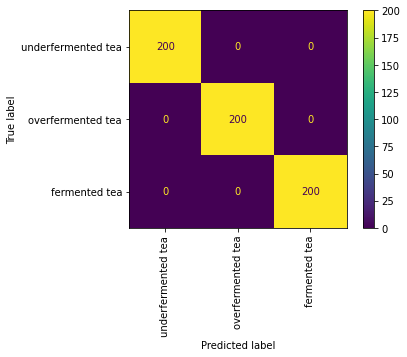

In [ ]:
preds_test = clf.predict(x_test)
cm = confusion_matrix(preds_test, y_test)
disp = ConfusionMatrixDisplay(cm, display_labels=classes.keys())
disp.plot(xticks_rotation='vertical');

Great! We yielded 100% accuracy on our oos predictions.

Finally, lets look at the importance of each feature and compare it with our previous boxplot to check if our hypothesis was correct.

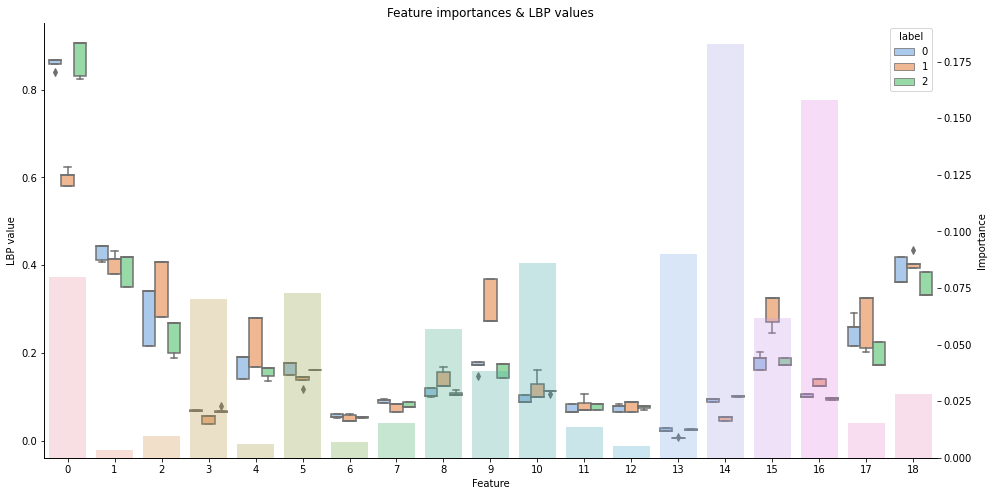

In [ ]:
rf_feature_importances = pd.DataFrame({'Feature': x_train.columns, 'Importance': clf.feature_importances_})
rf_feature_importances.sort_values(by='Importance', ascending=False, inplace=True)

plt.figure(figsize=(16, 8))
sns.boxplot(data=train_df.melt(id_vars='label'), x='variable', y='value', hue='label')
plt.ylabel('LBP value')
plt.xlabel('Feature')
ax2 = plt.twinx()
sns.barplot(data=rf_feature_importances, x='Feature', y='Importance', alpha=0.3, ax=ax2)
ax2.set_ylabel('Importance')
sns.despine()
plt.title('Feature importances & LBP values');